In [1]:
import os
import cv2
import pandas as pd

PROJ_DIR = '/Users/mpekey/Desktop/FlyVideo'
DATA_PATH = os.path.join(PROJ_DIR, 'Dataset')


### Label Distribution

In [2]:
labels = [label for label in os.listdir(DATA_PATH) if label != '.DS_Store']
labels

['Feeding', 'Grooming', 'Pumping']

In [17]:
video_count = 0

for label in labels:
    label_path = os.path.join(DATA_PATH, label)
    label_count = len(os.listdir(label_path))
    print(f'There are {label_count} videos for the {label} behaviour.')
    video_count += label_count
print('----------------------')

print(f'There are total of {video_count} videos')

There are 431 videos for the Feeding behaviour.
There are 540 videos for the Grooming behaviour.
There are 412 videos for the Pumping behaviour.
----------------------
There are total of 1383 videos


### Creating info CSV

Includes video features:

- File name
- Label
- FPS
- Total number of frames
- Height
- Width

In [49]:
data_dict = {
    'video_file':[],
    'label':[],
    'fps':[],
    'num_frame':[],
    'height':[],
    'width':[]
}

for label in labels:
    label_file_path = os.path.join(DATA_PATH, label)

    for video_path in os.listdir(label_file_path):

        video = cv2.VideoCapture(os.path.join(label_file_path, video_path))

        data_dict['video_file'].append(video_path)
        data_dict['label'].append(label)
        data_dict['fps'].append(video.get(cv2.CAP_PROP_FPS))
        data_dict['num_frame'].append(video.get(cv2.CAP_PROP_FRAME_COUNT))
        data_dict['height'].append(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        data_dict['width'].append(video.get(cv2.CAP_PROP_FRAME_WIDTH))

video_df = pd.DataFrame(data_dict)
video_df['duration'] = video_df['num_frame'] / video_df['fps']

video_df.head(3)

,video_file,label,fps,num_frame,height,width,duration
0,v_feeding_g01_716.avi,Feeding,30.0,281.0,800.0,1100.0,9.366667
1,v_feeding_g01_266.avi,Feeding,30.0,250.0,800.0,1100.0,8.333333
2,v_feeding_g01_514.avi,Feeding,30.0,580.0,800.0,1100.0,19.333333


In [50]:
video_df.to_csv(os.path.join(PROJ_DIR, 'video_info.csv'), index=False)

### Analyzing Video Features

Videos will be resized to (800, 1000). All of them has 30 fps.

In [51]:
video_df.describe()

,fps,num_frame,height,width,duration
count,1383.0,1383.000000,1383.000000,1383.000000,1383.000000
mean,30.0,471.167028,800.086768,1100.167751,15.705568
std,0.0,615.542355,3.226786,6.238453,20.518079
min,30.0,11.000000,800.000000,1100.000000,0.366667
25%,30.0,108.500000,800.000000,1100.000000,3.616667
50%,30.0,248.000000,800.000000,1100.000000,8.266667
75%,30.0,598.000000,800.000000,1100.000000,19.933333
max,30.0,5676.000000,920.000000,1332.000000,189.200000


### Load Info CSV

In [4]:
info_csv_path = os.path.join(PROJ_DIR, 'Supplementary_Files','video_info.csv')
video_df = pd.read_csv(info_csv_path)
video_df.head(3)

,video_file,label,fps,num_frame,height,width,duration
0,v_feeding_g01_716.avi,Feeding,30.0,281.0,800.0,1100.0,9.366667
1,v_feeding_g01_266.avi,Feeding,30.0,250.0,800.0,1100.0,8.333333
2,v_feeding_g01_514.avi,Feeding,30.0,580.0,800.0,1100.0,19.333333


### Further Analysis

Some videos are shorter than 1 seconds

In [4]:
video_df[video_df['num_frame'] == video_df['num_frame'].min()]

,video_file,label,fps,num_frame,height,width,duration
386,v_feeding_g01_453.avi,Feeding,30.0,11.0,800.0,1100.0,0.366667


Default number of frames in VideoMAE model is 16.

In [5]:
video_df[video_df['num_frame'] >= 16].shape

(1382, 7)

If we want to take the videos longer than 5 seconds only

In [6]:
video_df[video_df['duration'] >= 5].shape

(908, 7)

### Analyzing Data Creation Bias on Video Length

Using a Decision Tree with depth of 1, we are going to look if video length has a bias on fly behaviour due to creation of data.

In [5]:
video_df[['duration', 'label']]

,video_file,label,fps,num_frame,height,width,duration
0,v_feeding_g01_716.avi,Feeding,30.0,281.0,800.0,1100.0,9.366667
1,v_feeding_g01_266.avi,Feeding,30.0,250.0,800.0,1100.0,8.333333
2,v_feeding_g01_514.avi,Feeding,30.0,580.0,800.0,1100.0,19.333333
3,v_feeding_g01_528.avi,Feeding,30.0,210.0,800.0,1100.0,7.000000
4,v_feeding_g01_312.avi,Feeding,30.0,193.0,800.0,1100.0,6.433333


0.3904567571809763


[Text(0.5, 0.75, 'x[0] <= 40.2\ngini = 0.662\nsamples = 1383\nvalue = [431, 540, 412]'),
 Text(0.25, 0.25, 'gini = 0.665\nsamples = 1273\nvalue = [410, 460, 403]'),
 Text(0.75, 0.25, 'gini = 0.428\nsamples = 110\nvalue = [21, 80, 9]')]

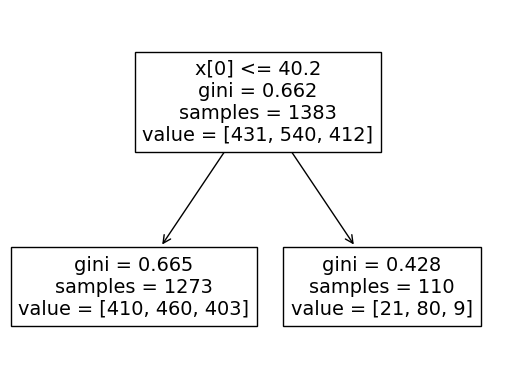

In [16]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier(max_depth=1, random_state=0)

X = video_df[['duration']].values
y = video_df[['label']].values

clf.fit(X, y)

print(np.mean(cross_val_score(clf, X, y, cv=5)))

plot_tree(clf)

### Creating Train and Validation Split

I will be using different sample rates but for now I decided to use sample_rate = 16 or lower. So because the fps is 30 and number of frames I want to generate is 8, the clip duration is 4.26. That's why I filter the data as duration >= 5

In [8]:
longer_video_df = video_df[video_df['duration'] >= 5]

In [10]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(longer_video_df, test_size=0.3, stratify=longer_video_df['label'], random_state=22)

In [14]:
train_df.head(3)

,video_file,label,fps,num_frame,height,width,duration
1304,prob_33_981244_981479.avi,Pumping,30.0,235.0,800.0,1100.0,7.833333
171,v_feeding_g01_613.avi,Feeding,30.0,1683.0,800.0,1100.0,56.100000
873,grooming_66_374362_375651.avi,Grooming,30.0,1289.0,800.0,1100.0,42.966667


In [15]:
import os
import pandas as pd
from shutil import copyfile

PROJ_DIR = '/Users/mpekey/Desktop/FlyVideo'
DATA_PATH = os.path.join(PROJ_DIR, 'Dataset')
OUTPUT_FOLDER = "FlyTrainingData"
label_names = ["Feeding", "Grooming", "Pumping"]

# Create the output folder and subfolders
os.makedirs(os.path.join(PROJ_DIR, OUTPUT_FOLDER, "Train"), exist_ok=True)
os.makedirs(os.path.join(PROJ_DIR, OUTPUT_FOLDER, "Validation"), exist_ok=True)

for label_name in label_names:
    os.makedirs(os.path.join(PROJ_DIR, OUTPUT_FOLDER, "Train", label_name), exist_ok=True)
    os.makedirs(os.path.join(PROJ_DIR, OUTPUT_FOLDER, "Validation", label_name), exist_ok=True)


In [17]:
# Copy the train videos to the output folder

def copy_data_to_subset(data, is_train=True):

    split_name = 'Train' if is_train else 'Validation'

    for index, row in data.iterrows():
        video_file = row["video_file"]
        label = row["label"]
        src_file = os.path.join(DATA_PATH, label, video_file)
        dst_file = os.path.join(PROJ_DIR, OUTPUT_FOLDER, split_name, label, video_file)
        copyfile(src_file, dst_file)


copy_data_to_subset(train_df, is_train=True)
copy_data_to_subset(val_df, is_train=False)

In [32]:
train_df.to_csv(os.path.join(PROJ_DIR, 'train_data_info.csv'), index=False)
val_df.to_csv(os.path.join(PROJ_DIR, 'val_data_info.csv'), index=False)